<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/PlantVillageDataSet/Test_experiments/plantVillageInceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
 


from tensorflow.keras.applications.inception_v3 import  InceptionV3,preprocess_input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout,BatchNormalization

 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/shared dataset platVillage/PlantVillage.tar.gz' 'PlantVillage.tar.gz'

In [ ]:
!tar -xf PlantVillage.tar.gz

In [ ]:
trainPath = '/content/PlantVillage/train'
lists = os.listdir(trainPath)
labels = []
file_lst = []

for folder in lists:
    files = os.listdir(trainPath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
train_df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(train_df)


                                                    path   label
0      Grape___healthy/51665d49-a91d-4790-a705-425d3b...   Grape
1      Grape___healthy/ddcf9afc-8a06-4778-8eba-95f8ef...   Grape
2      Grape___healthy/92fbe3df-dc85-4e06-8109-3a14f5...   Grape
3      Grape___healthy/ceb17d89-9a96-4b3b-8fa5-5d4b9e...   Grape
4      Grape___healthy/54ad35bc-3a1a-4cca-bc1b-167888...   Grape
...                                                  ...     ...
43439  Tomato___healthy/e6782c6b-bf00-492d-a30e-966fd...  Tomato
43440  Tomato___healthy/bae543d4-d61d-45e6-aa0c-eaf45...  Tomato
43441  Tomato___healthy/9e0cd9db-f893-4426-b195-5643b...  Tomato
43442  Tomato___healthy/6d7934cb-69fc-48fe-b493-a64b3...  Tomato
43443  Tomato___healthy/cb3ab315-c340-469c-8291-abe02...  Tomato

[43444 rows x 2 columns]


In [ ]:
validationPath = '/content/PlantVillage/val'
lists = os.listdir(validationPath)
labels = []
file_lst = []

for folder in lists:
    files = os.listdir(validationPath +"/"+folder)
    if(folder != 'background'): 
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
    

validation_df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(validation_df)


                                                    path   label
0      Grape___healthy/c0f3b55f-8078-4e91-aba7-9a187e...   Grape
1      Grape___healthy/9858eca1-78cb-4c9c-9286-ff52a2...   Grape
2      Grape___healthy/666536ee-371f-46c2-b20d-f6fc87...   Grape
3      Grape___healthy/36add77f-5e02-41b0-97e7-b1c14f...   Grape
4      Grape___healthy/caf1a7e7-8f7b-4127-929c-7d9c29...   Grape
...                                                  ...     ...
10856  Tomato___healthy/d247170c-6756-41f0-9074-09190...  Tomato
10857  Tomato___healthy/cf021ef4-2bde-4984-8604-c813c...  Tomato
10858  Tomato___healthy/ed76421e-84e4-408b-a1b3-c6164...  Tomato
10859  Tomato___healthy/a2317e6a-8548-432c-b69f-0f6da...  Tomato
10860  Tomato___healthy/83fa8d6f-4c08-46bf-b4cf-7a33d...  Tomato

[10861 rows x 2 columns]


In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/PlantVillage/train/',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/PlantVillage/val/',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

Found 43444 validated image filenames belonging to 14 classes.
Found 10861 validated image filenames belonging to 14 classes.


In [ ]:
print(train_generator.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry_(including_sour)': 2, 'Corn_(maize)': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper,_bell': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}


# Build InceptionV3 model

In [ ]:
class_number=14
def build_model_graph(class_number= class_number):
  base_model = InceptionV3(include_top=False,weights='imagenet',input_shape=(299, 299, 3))
  x= base_model.output
  x= GlobalAveragePooling2D()(x)
  x= Dropout(0.3)(x)
  x= Dense(256,activation='relu')(x)
  predictions=Dense(class_number,activation='softmax')(x)
  model=Model(base_model.input,predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:

model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
1358/1358 [==============================] - 876s 617ms/step - loss: 0.2090 - accuracy: 0.9411 - val_loss: 0.0105 - val_accuracy: 0.9975
Epoch 2/15
1358/1358 [==============================] - 831s 612ms/step - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.0065 - val_accuracy: 0.9983
Epoch 3/15
1358/1358 [==============================] - 835s 615ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 4/15
1358/1358 [==============================] - 837s 616ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 5/15
1358/1358 [==============================] - 836s 616ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0035 - val_accuracy: 0.9993
Epoch 6/15
1358/1358 [==============================] - 837s 616ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 7/15
1358/1358 [==============================] - 837s 616ms/step - loss: 0.0026 - accuracy: 0.9995 - val_

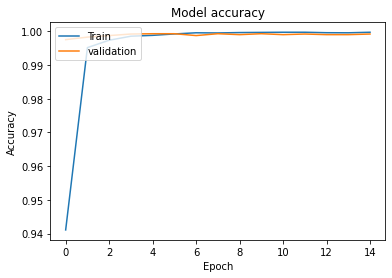

In [ ]:
 import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show() 

In [ ]:
hist = pd.DataFrame(hist.history) 

In [ ]:
InceptionArch = '/content/drive/MyDrive/Plant classification/Results/PlantVillageDataSet/IncepArch'
os.mkdir(InceptionArch) 

In [ ]:
hist_csv_file = '/content/drive/MyDrive/Plant classification/Results/PlantVillageDataSet/IncepArch/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist.to_csv(f)

In [ ]:
target_dir = '/content/drive/MyDrive/Plant classification/Results/PlantVillageDataSet/IncepArch'
architecture_name = "IncepArch"
#ct = str(datetime.datetime.now())
model.save(target_dir+'/'+architecture_name+'.h5')